In [2]:
from IPython.display import HTML
import time

handle = display(HTML("""<marquee>👌</marquee>"""), display_id='html_marquee1')
time.sleep(2)
handle = display(HTML("""<marquee>~ "There is a time for many words, and there is also a time for sleep." – Homer, The Odyssey</marquee>"""), display_id='html_marquee1', update=True)

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Executive Summary</div>

<div class="alert alert-block alert-info"> 📌 <b>Summary</b>: This notebook is intended to 
<ul>
    <li>Provide the exhaustive EDA on the dataset for <a href="https://www.kaggle.com/competitions/child-mind-institute-detect-sleep-states" target='_blannk'>Child Mind Institute - Detect Sleep States contest</a></li>
    <li>Perform the time series analysis of the sleeping events</li>
    <li>Summarize and evaluate feature engineering ideas (such a feature engineering is useful if you are going to tackle the prediction challenge as a tabular classification problem rather then a time series forecasting task)</li>
</ul></div>

<div class="alert alert-block alert-success"> 🧰 <b>Key highlights</b>:
    <ul>
        <li>TBD</li>
    </ul>
</div> 

Based on the insights derived in the EDA / data analytics drills across this notebook, the solid ML experiments can be set up down the road.

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Status of This Notebook</div>

<div style="color:black;
           display:fill;
           border-radius:5px;
           background-color:#fad3cf;
           font-size:90%;
           font-family:Verdana;
           letter-spacing:0.5px">
<b>Note to Readers:</b> It is essentially work in progress as of this moment. The incremental updates in future will add more content to the respective sections of the notebook.
</div>

In [3]:
import gc
import pandas as pd
import numpy as np
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline

from colorama import Fore, Style, init
from pprint import pprint




In [4]:
# Color printing
# inspired by https://www.kaggle.com/code/ravi20076/sleepstate-eda-baseline
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    "Prints color outputs using colorama using a text F-string";
    print(style + color + text + Style.RESET_ALL);

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">About the Competition and Its Dataset</div>

The **goal of the competition** is to detect sleep onset and wake. We are requested to develop a model trained on wrist-worn accelerometer data in order to determine a person's sleep state.

The training dataset is composed of
- The Multi-day recordings of wrist-worn accelerometer (provided as a parquet file).
- The labelling file with the data annotated with two event types: **onset**, the beginning of sleep, and **wakeup**, the end of the sleeping time (provided as a CSV file).

Both data files represent the essential time series-type data.

For the testing set, only the accelerometer-based data (in parquet format) are provided.

Essential summary on the data for the contest is quoted below, as per the note from the contest hosts

<blockquote>
    <div class="alert alert-block alert-success"> ✅ <b>Data description</b>: The dataset comprises about 500 multi-day recordings of wrist-worn accelerometer data annotated with two event types: onset, the beginning of sleep, and wakeup, the end of sleep. Your task is to detect the occurrence of these two events in the accelerometer series.<br><br>

While sleep logbooks remain the gold-standard, when working with accelerometer data we refer to sleep as the longest single period of inactivity while the watch is being worn. For this data, we have guided raters with several concrete instructions:

<ul>
    <li>A single sleep period must be at least 30 minutes in length</li>
    <li>A single sleep period can be interrupted by bouts of activity that do not exceed 30 consecutive minutes</li>
<li>No sleep windows can be detected unless the watch is deemed to be worn for the duration</li>
<li>The longest sleep window during the night is the only one which is recorded</li>
<li>If no valid sleep window is identifiable, neither an onset nor a wakeup event is recorded for that night.</li>
<li>Sleep events do not need to straddle the day-line, and therefore there is no hard rule defining how many may occur within a given period. However, no more than one window should be assigned per night. For example, it is valid for an individual to have a sleep window from 01h00–06h00 and 19h00–23h30 in the same calendar day, though assigned to consecutive nights.</li>
<li>There are roughly as many nights recorded for a series as there are 24-hour periods in that series.
</ul><br>
        
Though each series is a continuous recording, there may be periods in the series when the accelerometer device was removed. These period are determined as those where suspiciously little variation in the accelerometer signals occur over an extended period of time, which is unrealistic for typical human participants. Events are not annotated for these periods, and you should attempt to refrain from making event predictions during these periods: an event prediction will be scored as false positive.<br>

Each data series represents this continuous (multi-day/event) recording for a unique experimental subject.
    </div>
</blockquote>

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">train_series.parquet Details</div>

This file represents series to be used as training data. Each series is a continuous recording of accelerometer data for a single subject spanning many days.

The table below summarizes the structure of the initial accelerometer data provided:

<style>
#features {
  font-family: Arial, Helvetica, sans-serif;
  border-collapse: collapse;
  width: 100%;
}

#features td, #features th {
  border: 1px solid #ddd;
  padding: 8px;
}

#features tr:nth-child(even){background-color: #f2f2f2;}

#features tr:hover {background-color: #ddd;}

#features th {
  padding-top: 12px;
  padding-bottom: 12px;
  text-align: left;
  background-color: #CBC3E3;
  color: white;
}
</style>

<table id="features">
    <tr>
        <th>Attribute</th>
        <th>Description</th>
        <th>Comments</th>
    </tr>
    <tr>
      <td><b><i>series_id</i></b></td>
      <td>Unique identifier for each accelerometer series</td>
      <td>&nbsp;</td>
    </tr>
    <tr>
      <td><b><i>step</i></b></td>
      <td>An integer timestep for each observation within a series.</td>
      <td>It is unique within a series</td>
    </tr>
    <tr>
      <td><b><i>timestamp</i></b></td>
      <td>A corresponding datetime in ISO 8601 format: <i>%Y-%m-%dT%H:%M:%S%z.</i></td>
      <td>&nbsp;</td>
    </tr>
    <tr>
      <td><b><i>anglez</i></b></td>
      <td>As calculated and described by the GGIR package, z-angle is a metric derived from individual accelerometer components that is commonly used in sleep detection, and refers to the angle of the arm relative to the vertical axis of the body</td>
        <td>You can refer to <a href="https://cran.r-project.org/web/packages/GGIR/vignettes/GGIR.html#4_Inspecting_the_results" target="_blank">Accelerometer data processing with GGIR</a> for more details</td>
    </tr>
    <tr>
      <td><b><i>enmo</i></b></td>
      <td>As calculated and described by the GGIR package, ENMO is the Euclidean Norm Minus One of all accelerometer signals, with negative values rounded to zero. While no standard measure of acceleration exists in this space, this is one of the several commonly computed features</td>
      <td>You can refer to <a href="https://cran.r-project.org/web/packages/GGIR/vignettes/GGIR.html#4_Inspecting_the_results" target="_blank">Accelerometer data processing with GGIR</a> for more details</td>
    </tr>
</table>

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">test_series.parquet Details</div>

This file contains the details on the series to be used as the test data, containing the same fields as above. The goal is to predict event occurrences for series in this file.


## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">train_events.csv Details</div>

This file represents series to be used as training data. Each series is a continuous recording of accelerometer data for a single subject spanning many days.

The table below summarizes the structure of the initial accelerometer data provided:

<style>
#features {
  font-family: Arial, Helvetica, sans-serif;
  border-collapse: collapse;
  width: 100%;
}

#features td, #features th {
  border: 1px solid #ddd;
  padding: 8px;
}

#features tr:nth-child(even){background-color: #f2f2f2;}

#features tr:hover {background-color: #ddd;}

#features th {
  padding-top: 12px;
  padding-bottom: 12px;
  text-align: left;
  background-color: #CBC3E3;
  color: white;
}
</style>

<table id="features">
    <tr>
        <th>Attribute</th>
        <th>Description</th>
        <th>Comments</th>
    </tr>
    <tr>
      <td><b><i>series_id</i></b></td>
      <td>Unique identifier for each accelerometer series, corresponding to the identifies for each series of accelerometer data in <i>train_series.parquet.</i></td>
      <td>&nbsp;</td>
    </tr>
    <tr>
      <td><b><i>night</i></b></td>
        <td>An enumeration of potential <i>onset / wakeup</i> event pairs. At most one pair of events can occur for each night.</td>
      <td>&nbsp;</td>
    </tr>
    <tr>
      <td><b><i>event</i></b></td>
        <td>The type of event, whether <i>onset</i> or <i>wakeup</i>.</td>
      <td>&nbsp;</td>
    </tr>
    <tr>
      <td><b><i>step</i></b></td>
      <td>An integer timestep for each observation within a series.</td>
      <td>It is unique within a series</td>
    </tr>
    <tr>
      <td><b><i>timestamp</i></b></td>
      <td>The recorded time of occurence of the event in the accelerometer series in ISO 8601 format: <i>%Y-%m-%dT%H:%M:%S%z.</i></td>
      <td>&nbsp;</td>
    </tr>
</table>

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Reading Data</div>

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Initial Data Inspection</div>

First of all, we are going to read the data in memory.

Since the size of the dataset (especially, its parquet parts with accelerometer data feeds) is quite big, time- and memory-effective data loading should be implemented.

Therefore, we are going to use Polars, the fast alternative to Pandas. So, out data loading strategy is going to be as follows
Apache Parquet（Parquet）はHadoopの各種プロジェクトで利用できるオープンソースのファイルフォーマットです。 カラムナフォーマットと呼ばれるデータ保存形式で、必要なカラムのみを読み込むことでIOを削減し、データアクセス速度の向上を実現します。
- use Polars to read both the parquet and csv files in memory
- convert the output to the Pandas dataframes to enable data analytics and EDA experiments as needed
- as a part of such data loading, we will also extract the features from timestamp values in series and events data (namely, we will decompose the timestamps into year, month, day, and hour components to enable insight-reach EDA down the road)
- compress the series data in memory by reducing the RAM usage by the respective Pandas dataframes

<div class="alert alert-block alert-info"> ✅ <b>Note</b>: Pandas is an essential Python library for Data Science. But its biggest downside is that it can be slow for operations on large datasets. Polars is a Pandas alternative designed to process data faster. You can refer to the references provided in "References" chapter below to learn more about Polars.</div>


In [5]:
root_path = "C:/Users/illbe/DataspellProjects/ChildMindInstitute/Resources"


In [6]:
%%time
# inspired by https://www.kaggle.com/code/enricomanosperti/detect-sleep-states-first-preprocessing-and-eda
import polars as pl
root_path = "C:/Users/illbe/DataspellProjects/ChildMindInstitute/Resources"
train_series = (pl.scan_parquet(root_path + '/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet')
                .with_columns(
                    (
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.year().alias("year")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.month().alias("month")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.day().alias("day")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.hour().alias("hour")),
                    )
                )
                .collect()
                .to_pandas()
               )

CPU times: total: 1min 4s
Wall time: 47.5 s


In [7]:
train_series.head()

,series_id,step,timestamp,anglez,enmo,year,month,day,hour
0,038441c925bb,0,2018-08-14 15:30:00,2.6367,0.0217,2018,8,14,15
1,038441c925bb,1,2018-08-14 15:30:05,2.6368,0.0215,2018,8,14,15
2,038441c925bb,2,2018-08-14 15:30:10,2.6370,0.0216,2018,8,14,15
3,038441c925bb,3,2018-08-14 15:30:15,2.6368,0.0213,2018,8,14,15
4,038441c925bb,4,2018-08-14 15:30:20,2.6368,0.0215,2018,8,14,15


In [8]:
train_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127946340 entries, 0 to 127946339
Data columns (total 9 columns):
 #   Column     Dtype         
---  ------     -----         
 0   series_id  object        
 1   step       uint32        
 2   timestamp  datetime64[ns]
 3   anglez     float32       
 4   enmo       float32       
 5   year       int32         
 6   month      uint32        
 7   day        uint32        
 8   hour       uint32        
dtypes: datetime64[ns](1), float32(2), int32(1), object(1), uint32(4)
memory usage: 5.2+ GB


In [9]:
%%time
train_events = (pl.scan_csv(root_path + '/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv')
                .with_columns(
                    (
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.year().alias("year")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.month().alias("month")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.day().alias("day")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.hour().alias("hour")),
                    )
                )
                .collect()
                .to_pandas()
               )

CPU times: total: 31.2 ms
Wall time: 127 ms


In [10]:
train_events.head()

,series_id,night,event,step,timestamp,year,month,day,hour
0,038441c925bb,1,onset,4992.0,2018-08-14 22:26:00,2018.0,8.0,14.0,22.0
1,038441c925bb,1,wakeup,10932.0,2018-08-15 06:41:00,2018.0,8.0,15.0,6.0
2,038441c925bb,2,onset,20244.0,2018-08-15 19:37:00,2018.0,8.0,15.0,19.0
3,038441c925bb,2,wakeup,27492.0,2018-08-16 05:41:00,2018.0,8.0,16.0,5.0
4,038441c925bb,3,onset,39996.0,2018-08-16 23:03:00,2018.0,8.0,16.0,23.0


In [11]:
train_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14508 entries, 0 to 14507
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   series_id  14508 non-null  object        
 1   night      14508 non-null  int64         
 2   event      14508 non-null  object        
 3   step       9585 non-null   float64       
 4   timestamp  9585 non-null   datetime64[ns]
 5   year       9585 non-null   float64       
 6   month      9585 non-null   float64       
 7   day        9585 non-null   float64       
 8   hour       9585 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 1020.2+ KB


In [12]:
%%time
test_series = (pl.scan_parquet(root_path + '/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet')
                .with_columns(
                    (
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.year().alias("year")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.month().alias("month")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.day().alias("day")),
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.hour().alias("hour")),
                    )
                )
                .collect()
                .to_pandas()
               )

CPU times: total: 0 ns
Wall time: 5 ms


In [13]:
test_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   series_id  450 non-null    object        
 1   step       450 non-null    uint32        
 2   timestamp  450 non-null    datetime64[ns]
 3   anglez     450 non-null    float32       
 4   enmo       450 non-null    float32       
 5   year       450 non-null    int32         
 6   month      450 non-null    uint32        
 7   day        450 non-null    uint32        
 8   hour       450 non-null    uint32        
dtypes: datetime64[ns](1), float32(2), int32(1), object(1), uint32(4)
memory usage: 19.5+ KB


Before we do the analytical drills, let's optimize the RAM consumption of the notebook, with compressing the series data in memorty.

In [14]:
%%time
# inspired by https://www.kaggle.com/code/renatoreggiani/reduce-memory-usage-zzzs-cmi
# with tweaks determined by the selected polars loading strategy
# tweaks inspired by https://github.com/softhints/Pandas-Tutorials/blob/master/column/3.check-dtype-column-columns-pandas-dataframe.ipynb
from pandas.api.types import is_datetime64_ns_dtype
def reduce_mem_usage(df):
    """ iterate through all numeric columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')
    
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and not is_datetime64_ns_dtype(df[col]):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float16)

    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimization is: {end_mem:.2f} MB')
    decrease = 100 * (start_mem - end_mem) / start_mem
    print(f'Decreased by {decrease:.2f}%')
    
    return df

train_series = reduce_mem_usage(train_series)

Memory usage of dataframe is 5368.84 MB
Memory usage after optimization is: 3904.61 MB
Decreased by 27.27%
CPU times: total: 2.62 s
Wall time: 4.18 s


In [15]:
%%time
test_series = reduce_mem_usage(test_series)

Memory usage of dataframe is 0.02 MB
Memory usage after optimization is: 0.01 MB
Decreased by 31.61%
CPU times: total: 0 ns
Wall time: 5 ms


## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Missing Values Review: Train Events Data</div>

Let's review the spread of the missing values in the train events data.

In [16]:
for col in train_events.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col,100*(train_events[col].isnull().sum()/train_events[col].shape[0]))
    PrintColor(f"\n---> {msg}");
    #print(msg)


---> column:  series_id	 Percent of NaN value: 0.00%

---> column:      night	 Percent of NaN value: 0.00%

---> column:      event	 Percent of NaN value: 0.00%

---> column:       step	 Percent of NaN value: 33.93%

---> column:  timestamp	 Percent of NaN value: 33.93%

---> column:       year	 Percent of NaN value: 33.93%

---> column:      month	 Percent of NaN value: 33.93%

---> column:        day	 Percent of NaN value: 33.93%

---> column:       hour	 Percent of NaN value: 33.93%


Now, let's visualize the missing values spread in the dataset. 

<div class="alert alert-block alert-info"> ✅ <b>Tip</b>: The good instrument to quickly visualize the missing values in a dataset is the specialized library - <i><b>missingno</b></i>. We are going to demonstrate it below.
</div>

First of all, we will look at the ratio of the missing values as a bar chart

<Axes: >

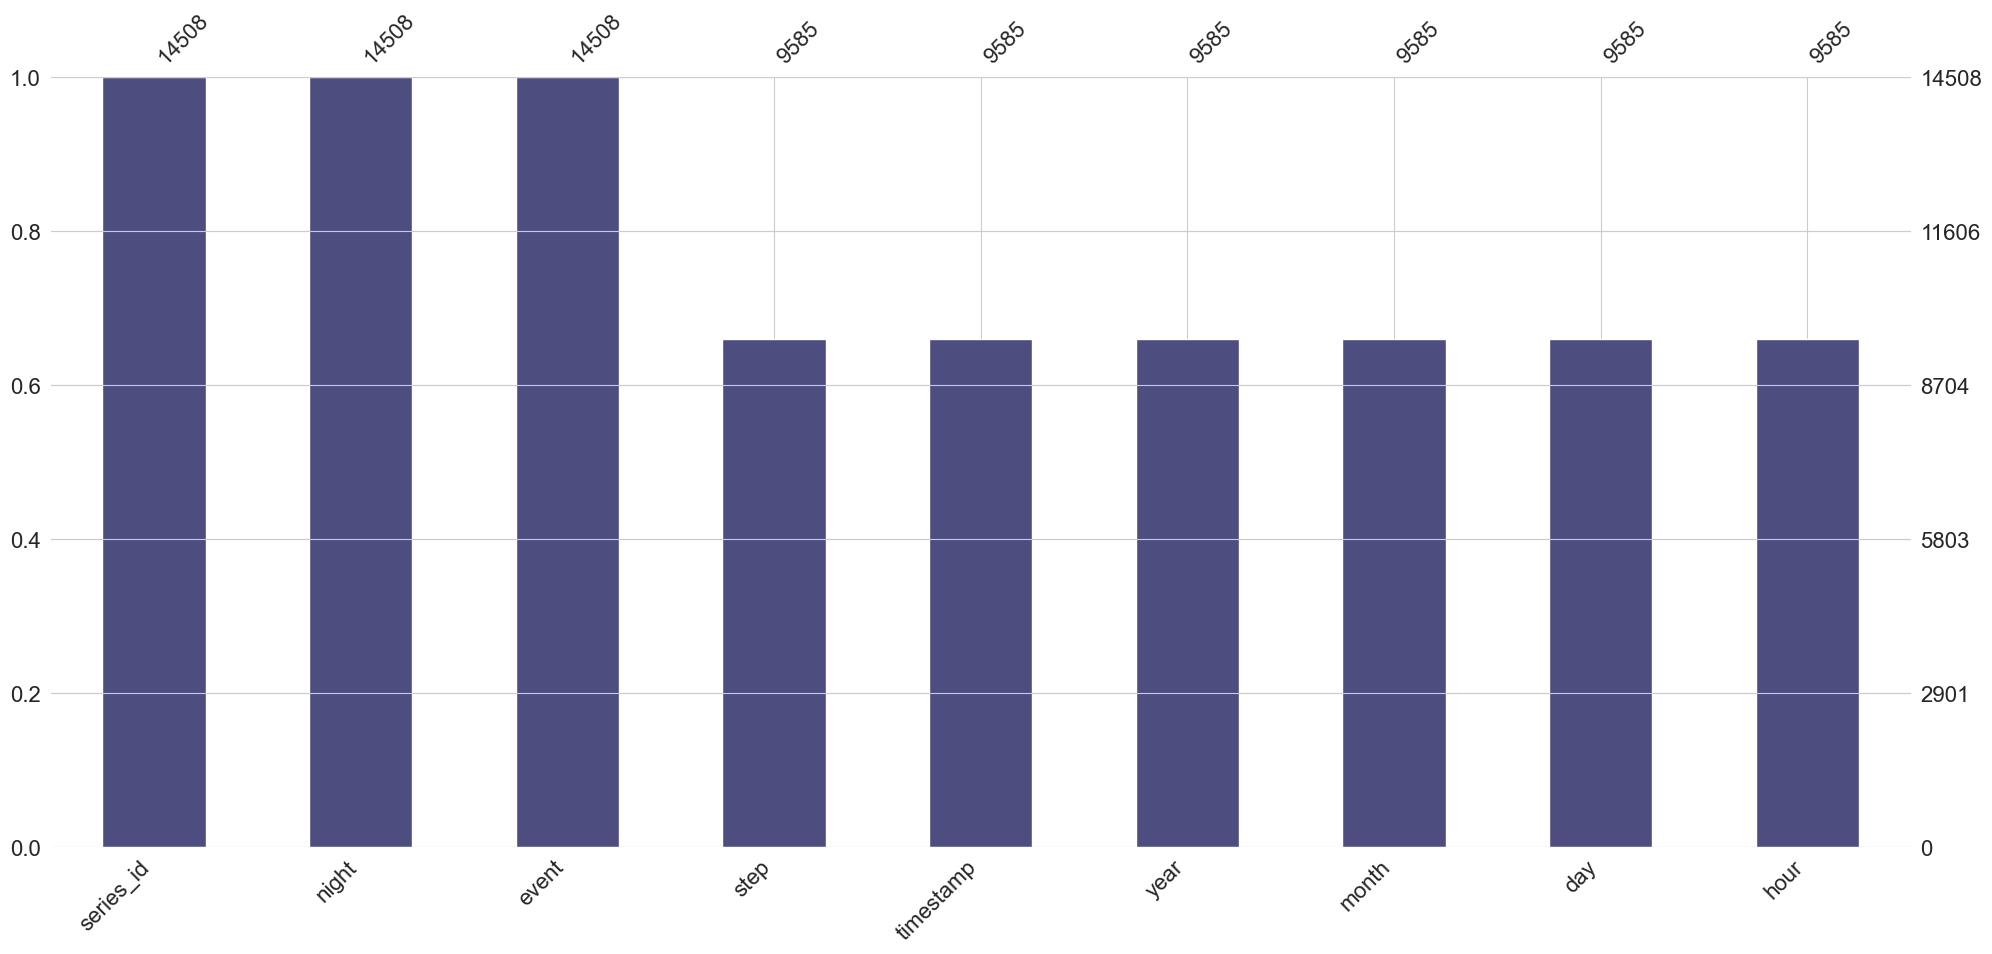

In [17]:
import missingno as msno

msno.bar(train_events, color=(0.3,0.3,0.5))

Now we are going to look at the actual records inn the train events data affected in the matrix view

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

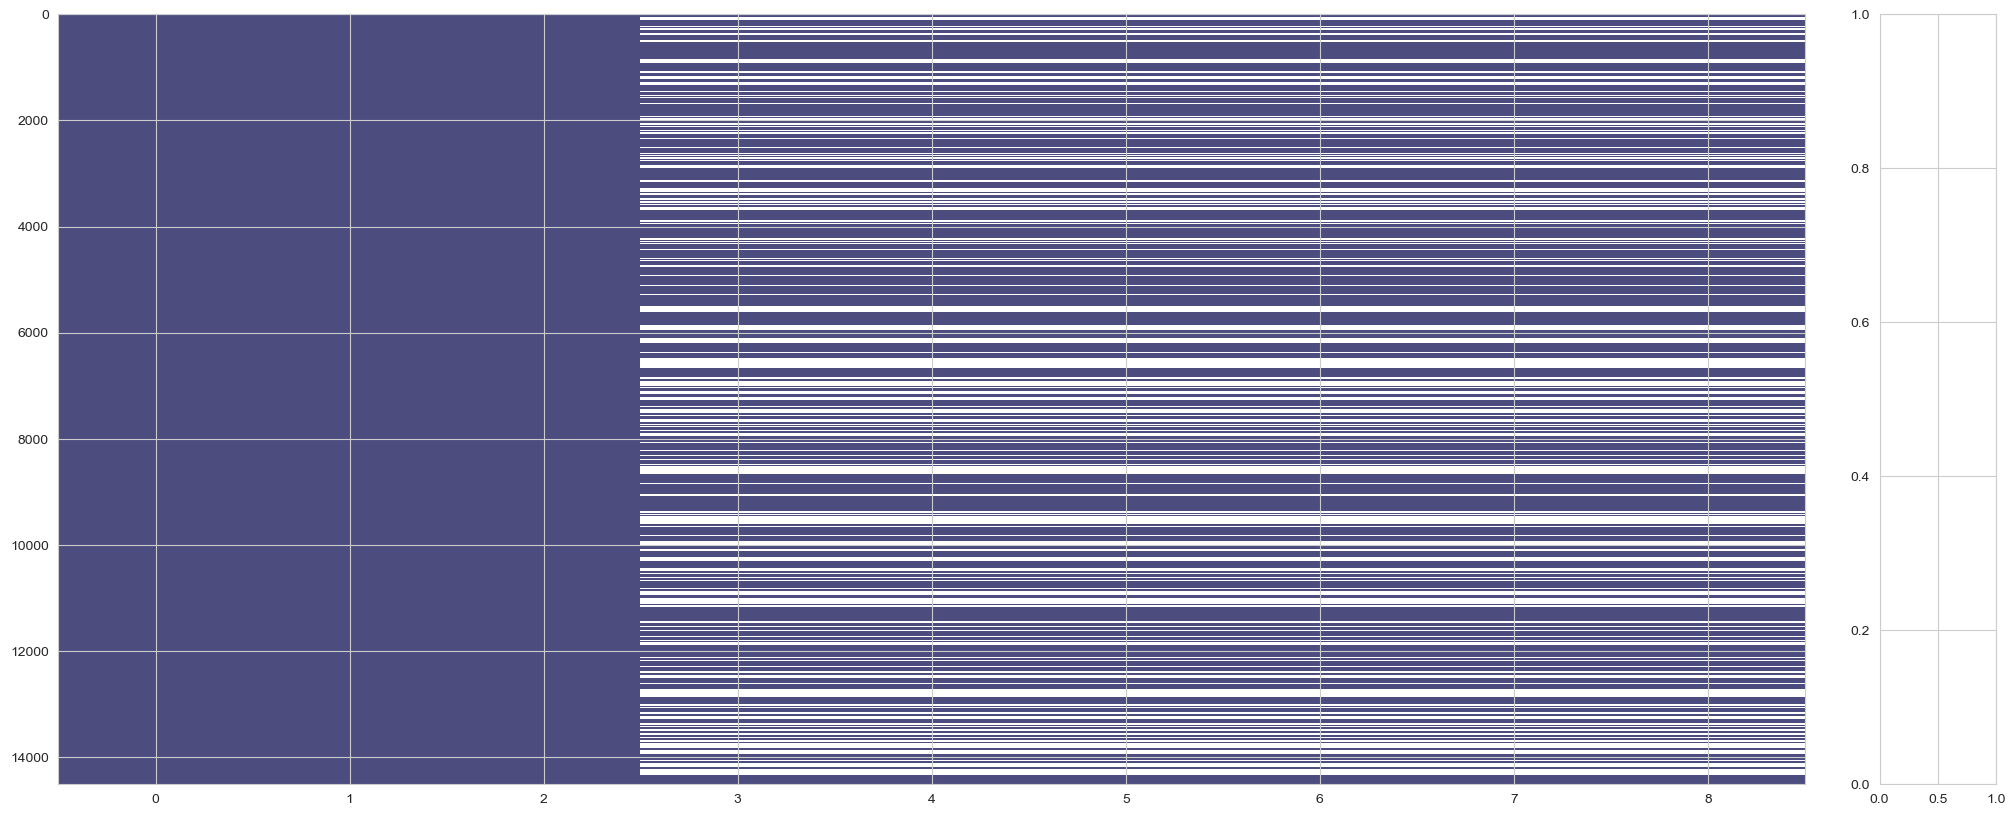

In [18]:
msno.matrix(train_events, color=(0.3,0.3,0.5))

As we can see, 

- There is a fraction of the series with incomplete labelling of sleeping/wakening events. 
- As we can see from the diagrams, the event labelling for such series is somewhat shrinked by certain dates.
- Another insight is, the % of missing data in *step* and *timestamp* attributes is quite high (*33.93%*). 

It makes it really unproductive to attempt to impute such missing values with any synthetical approach as it would introduce the type 2 noise in our dataset. If we do not find the logically determinant way of filling the missing values, it  would be better to shrink the incompletely labelled series from the training set exposed to the ML experiments down the road.

Let's look at the training events deeper to understand the impact of the shrinked labelling for some of the time series.

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Missing Values Review: Train Series Data</div>

Let's review the spread of the missing values in the train series data.

In [ ]:
for col in train_series.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col,100*(train_series[col].isnull().sum()/train_series[col].shape[0]))
    PrintColor(f"\n---> {msg}");
    #print(msg)

We find that there are no missing values in the train series data (accelerometer-based time series).

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Labelling Coverage for Train Series Data</div>

Let's review how many seires are fully labelled with the events.

In [ ]:
# base statistics
train_events.describe(include='all')

We find that
- There are *277* unique series in the train events (labels) file
- The length of the series ranges from *1 to 84*  nights, with the median to be *14* nights and the average length to be around *15* nights
- The observations that collected series data were between *'2017-08-05 22:44:00'* and *'2019-07-05 05:33:00'*, UTC 
- The series with the most labelled events has *id = '78569a801a38'*
- There are NaN values in the *step* column, which means that we can not use those instances for generating the label
- It may sound we will have to choose only those series that do not have any missing steps events

Now, let's visualize how many training series have full coverage with event labelling

In [ ]:
series_steps = train_events.groupby(['series_id'])['step'].apply(lambda x: x.isnull().any())

frame = {'series_id': series_steps.index,
         'has_missing_labels': series_steps}
 
# Creating DataFrame by passing Dictionary
agg_data = pd.DataFrame(frame)

dfg = agg_data['has_missing_labels'].value_counts().reset_index()
dfg.columns = ['has_missing_labels', 'number_of_series']
fig = px.bar(dfg, x='has_missing_labels', y='number_of_series', 
             title='Series with and without missing event labels',
            color_discrete_sequence=px.colors.qualitative.Prism) 
fig.show()

We find that only *37* series out of *277* have fully labelled training events. Such series are going to be used in the model training down the road.

Let's display the ids of series with fully labelled events.

In [ ]:
no_NaN_series = series_steps[~series_steps].index.tolist()

PrintColor(f"\n---> Displaing the ids of series with fully labelled events:\n");
pprint(no_NaN_series, indent = 10, width = 50);

# print(no_NaN_series)

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Data Inspection Summary</div>

Below are the major takeaways from our data inspection drill

- Train events csv fill shall be used to generate the label data for train series provided as a parquet file.
- The envisioned ML approaches is to tackle either a binary (Awake/Onset) or multiclass (namely, 3-class) event classification problem (with target classess to be Awake, Onset, and Other).
- The significant fraction of the series provided in the training set has incomplete labelling; therefore, one of the approaches to training the ML/DL models for this contest is to prepare a training subset with completely labelled series only.
- We should have a look at individual series to get deeper-level insights about the data. The focus should be on *37* series with complete event labelling data we identified above.

<div class="alert alert-block alert-info"> ✅ <b>Note</b>: It was Carl McBride Ellis who first paid attention to the issue with incomplete labelling for some of the series within this dataset. He put together a <a href="https://www.kaggle.com/datasets/carlmcbrideellis/zzzs-lightweight-training-dataset-target" target="_blank">smaller dataset</a> with 35 well-formed series to use in model training down the road.
</div>

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Deep Dive into Training Events</div>

Let's dive deeper into training events data to mine more insights.

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">General Summary for Train Events Data</div>

In [ ]:
# inspired by https://www.kaggle.com/code/rishabh15virgo/cmi-dss-first-impression-data-understanding-eda
def summarize_dataframe(df):
    summary_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary_df['missing#'] = df.isna().sum().values*100
    summary_df['missing%'] = (df.isna().sum().values*100)/len(df)
    summary_df['uniques'] = df.nunique().values
    summary_df['count'] = df.count().values
    #sum['skew'] = df.skew().values
    desc = pd.DataFrame(df.describe().T)
    summary_df['min'] = desc['min']
    summary_df['max'] = desc['max']
    summary_df['mean'] = desc['mean']
    return summary_df

summarize_dataframe(train_events).style.background_gradient(cmap='Purples')

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Training Events Density</div>

Let's visualize the density of the train_series. In fact, it will draw the availability matrix for the events across the series and dates (1: available; 0: NaN).

This visualization helps to digest the periods during which events (*'onset'* and *'wakeup'*) have been recorded.

We are going to engage with clustermap for this visualization, where the y-axis represents individual time series clustered based on their data collection similarity.

In [ ]:
# Pivot the DataFrame to create df_availability
tr_ev = train_events.copy()
tr_ev['dates'] = tr_ev['timestamp'].dt.date
df_availability = tr_ev.pivot_table(columns='dates', index='series_id', values='step', aggfunc='count')

# Fill NA values with 0
df_availability = (~df_availability.isna()).fillna(0).astype('int')

# Plotting the clustered heatmap
sns.clustermap(df_availability, col_cluster=False, figsize=(12, 8))

# TODO: re-implement for plotly per
# https://stackoverflow.com/questions/66547583/plotly-clustered-heatmap-with-dendrogram-python
# https://plotly.com/python/clustergram/#default-clustergram
# https://plotly.com/python/dendrogram/

Upon examining the clustermap, it is evident that the majority of the series tend to have a duration spanning 20 to 30 days (see  also below for the night-based insights into the series durations).

The periods of time during which data have been collected are sparsely distributed across the years 2017 to 2019.

Whenever timestamps are discussed, it is essential to note the relations between 
- *steps* and *timestamps*
- impact of the sparsity of the series data on the usability of time-driven features

As per the description of the dataset, *step* is the basis for the evaluation of submitted predictions. *timestamps*, in turn, is generally used as an input for features (provided you tackle the prediction problem in the tabular classification setup).

Since the training seria samples are very sparse, it could look like that only hourly/minute trends could make some sense for the model. Trends of higher scale (daily, weekly etc.) would be misleading for the model to train in turn.

<div class="alert alert-block alert-info"> ✅ <b>Note</b>: More advanced time series insights on <i>enmo/anglez</i> are collected in a <a href="https://www.kaggle.com/code/gvyshnya/plotting-big-data-sleeping-series" target="_blank">separate notebook</a>. More specifically, it will contain the results of the clustering experiments to group series by the statistical trends displayed by <i>enmo/anglez</i> aggregated values.
</div>

In [ ]:
del tr_ev, df_availability

# Returns the number of
# objects it has collected
# and deallocated
collected = gc.collect()
 
# Prints Garbage collector
# as 0 object
print("Garbage collector: collected",
          "%d objects." % collected)# Importing gc module

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Balance Between Onset and Wakeup Events</div>

Let's now visualize the frequency of *onset* and *wakeup* events by hours in a day.

In the context, *onset* and *wakeup* events signify the times people go to sleep and wake up, respectively.

Understanding the temporal patters in manifesting these events can draw critical insights into the sleeping behavior.

In [ ]:
df_onset = train_events[train_events['event'] == 'onset']
df_wakeup = train_events[train_events['event'] == 'wakeup']

fig = make_subplots(rows=1, cols=2, subplot_titles=('<b>Hourly Distr. of Onset Events</b>',
                                                    '<b>Hourly Distr. of Wakeup Events</b>',
                                                   ))

fig.add_trace(go.Histogram(x=df_onset['hour'].dropna(), nbinsx=24), row=1, col=1)
fig.add_trace(go.Histogram(x=df_wakeup['hour'].dropna(), nbinsx=24), row=1, col=2)
                                
# Update visual layout
fig.update_layout(
    showlegend=False,
    width=600,
    height=400,
    autosize=False,
    margin=dict(t=15, b=0, l=5, r=5),
    template="plotly_white",
    colorway=px.colors.qualitative.Prism ,
)

# update font size at the axes
fig.update_coloraxes(colorbar_tickfont_size=10)
# Update font in the titles: Apparently subplot titles are annotations (Subplot font size is hardcoded to 16pt · Issue #985)
fig.update_annotations(font_size=12)
# Reduce opacity
fig.update_traces(opacity=0.75)

fig.show()

In the resulting histograms, the x-axis denotes the 24-hour timeline, and the y-axis represents the frequency of *onset* and *wakeup* events.

From the charts displayed, it is evident that the majority of individuals whose sleeping series are represented in the training dataset tend to 
- wake up between 6-8 am;
- go to sleep around 8-10 pm.

Such a temporal pattern matches well with general intuition as well as provides a useful baseline for further analyses.

Let's now review the balance between the labelled *onset* and *wakeup* events in the training dataset.

In [ ]:
agg_data = train_events[["event", "hour"]].groupby(["event", "hour"]).size().reset_index(name="count")
agg_data["hour"] = agg_data["hour"].astype(int)
# define figure element
fig = px.sunburst(
    agg_data,
    values='count',
    path=["event", "hour"],
    title="Events by hours in a day",
    color="event",
    height=600,
    color_discrete_sequence=px.colors.qualitative.Prism,
    #color_continuous_scale=px.colors.sequential.Viridis
)
# display the figure
fig.show()

As we can see, the number of *onset* and *wakeup* events is quite balanced in the training dataset, which indicates no labelling errors on the series where labels were generated (either fully or parcially).

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Event Minute Patterns</div>

Let's review the distribution of *onset/wakeup* events within the minutes of 15-min intervals (if we split the entire timeline of the training series into such 15-min intervals, it would be interesting to search for any regular pattern in the event distribution).

In [ ]:
mn_train_events = pd.read_csv(root_path + '/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv')
mn_train_events = mn_train_events.loc[~mn_train_events['timestamp'].isna()] # drop NA

df_onset_mn = mn_train_events[mn_train_events['event'] == 'onset']
df_wakeup_mn = mn_train_events[mn_train_events['event'] == 'wakeup']

min15_onset = df_onset_mn['timestamp'].str[-10:-8].astype('int32')%15 # minute of event, in 15 min blocks
min15_wakeup = df_wakeup_mn['timestamp'].str[-10:-8].astype('int32')%15 # minute of event, in 15 min blocks

frame1 = {'interval': min15_onset.index,
         'onset_minute': min15_onset}
 
# Creating DataFrame by passing Dictionary
agg_data_onsets = pd.DataFrame(frame1)

frame2 = {'interval': min15_wakeup.index,
         'wakeup_minute': min15_wakeup}
 
# Creating DataFrame by passing Dictionary
agg_data_wakeups = pd.DataFrame(frame2)


#h=plt.hist(min15, bins=50)
#plt.show()

fig = make_subplots(rows=1, cols=2, subplot_titles=('<b>Distr. of Onset Events in 15-min intervals</b>',
                                                    '<b>Distr. of Wakeup Events in 15-min intervals</b>',
                                                   ))

fig.add_trace(go.Histogram(x=agg_data_onsets['onset_minute'].dropna(), nbinsx=24), row=1, col=1)
fig.add_trace(go.Histogram(x=agg_data_wakeups['wakeup_minute'].dropna(), nbinsx=24), row=1, col=2)
                                
# Update visual layout
fig.update_layout(
    showlegend=False,
    width=700,
    height=400,
    autosize=False,
    margin=dict(t=15, b=0, l=5, r=5),
    template="plotly_white",
    colorway=px.colors.qualitative.Prism ,
)

# update font size at the axes
fig.update_coloraxes(colorbar_tickfont_size=10)
# Update font in the titles: Apparently subplot titles are annotations (Subplot font size is hardcoded to 16pt · Issue #985)
fig.update_annotations(font_size=12)
# Reduce opacity
fig.update_traces(opacity=0.75)

fig.show()


We can observe a strange pattern in the event records, if they are looked up on 15-min intervals.

- They are always on exact minutes, maybe due to the manual classification/labelling  leading to limited precision
- They demonstrate repeatable patterns in 15 minutes cycle
- The most of events (both *onset* and *wakeup*) happen on 0th, 3rd, 7th, and 11th minutes of 15-min intervals (0 stands for the first minute of the interval, and 14 stands for the last one)
- The distribution and period of minute differ by event type, if looking at the more granular level 

Additional note for *wakeups*, we can see almost regularly equal number of events in every minute category within the 4 event frequency buckets there
- the most frequent event minutes (0, 3, 7, 11 minutes)
- second the most frequent event minutes (2, 6, 10, 14 minutes) - they stay 1 min behind the minutes in the most frequent bucket, btw
- modereate events bucket minutes (4, 8, 12 minutes)
- least frequent event bucket (1, 5, 9, 13 minutes)

It is hard to expain the rationale behind the patterns observed. Nor is it clear if it is possible to use such a discovery in the ML solutions to predict the sleeping events down the road.

<div class="alert alert-block alert-info"> ✅ <b>Note</b>: Such a strange phenomenon has been first mentioned in one of the <a href="https://www.kaggle.com/competitions/child-mind-institute-detect-sleep-states/discussion/444374" target="_blank">discussion threads</a>.</div>

In [ ]:
del mn_train_events, df_onset_mn, df_wakeup_mn, agg_data_onsets, agg_data_wakeups, frame1, frame2

# Returns the number of
# objects it has collected
# and deallocated
collected = gc.collect()
 
# Prints Garbage collector
# as 0 object
print("Garbage collector: collected",
          "%d objects." % collected)# Importing gc module

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Sleep Duration</div>

Let's review how many hours the people observed in the training set sleep in average.

In [ ]:
# inspired by https://www.kaggle.com/code/alinasri/sleep-data-analysis-some-eda

# Lets focus on non null rows of the training events only
mask_nonull= (~train_events['step'].isnull()) & (~train_events['timestamp'].isnull()) 
train_events_nonull = train_events[mask_nonull]

# Group by 'series_id' and calculate sleep duration for each night
sleep_duration_df = train_events_nonull.groupby([train_events_nonull['series_id'], train_events_nonull['night']])['timestamp'].agg(['min', 'max']).reset_index()
sleep_duration_df = sleep_duration_df.rename(columns={'min': 'onset', 'max': 'wakeup'})
sleep_duration_df['sleep_duration'] = ((sleep_duration_df['wakeup'] - sleep_duration_df['onset']).dt.seconds / 3600).round(0)

dfg = sleep_duration_df['sleep_duration'].value_counts().reset_index()
dfg.columns = ['sleep_duration', 'number_of_observations']
fig = px.bar(dfg, x='sleep_duration', y='number_of_observations', 
             title='Sleep Duration, Training seria (hours)',
            color_discrete_sequence=px.colors.qualitative.Prism) 
fig.show()

We can see that the most of the training observations (within the series-to-nights dimensions) demonstrated the sleep duration to be between 8 and 10 h per night (day), with the sleeping time of 9 h per day to be the most frequent value. 

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Nights Data Insights</div>

In [ ]:
nights_in_series = train_events.groupby('series_id')['night'].max()

frame = {'series_id': nights_in_series.index,
         'number_of_nights_in_seria': nights_in_series}
 
# Creating DataFrame by passing Dictionary
agg_data = pd.DataFrame(frame)

fig = px.histogram(agg_data, x="number_of_nights_in_seria", marginal="rug",
                   title='Distribution of Nights per Series in Training Events',
                   color_discrete_sequence=px.colors.qualitative.Prism)
fig.show()

We find that

- the majority of the series has *20-29* nights in it
- the second 'cluster' contains the series with *30-39* nights in it
- the tails of the distribution are minor; 
- we can indicate there are exceptionally long ('outlier') series with *84* and *62* nights, respectively

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Steps Data Insights</div>

In [ ]:
min_steps_in_series = train_series.groupby('series_id')['step'].min()
max_steps_in_series = train_series.groupby('series_id')['step'].max()

frame1 = {'series_id': min_steps_in_series.index,
         'min_number_of_steps_in_seria': min_steps_in_series}

frame2 = {'series_id': max_steps_in_series.index,
         'max_number_of_steps_in_seria': max_steps_in_series}
 
# Creating DataFrames by passing Dictionary
min_steps_df = pd.DataFrame(frame1)
max_steps_df = pd.DataFrame(frame2)

min_steps_df.reset_index(drop = True, inplace = True)
max_steps_df.reset_index(drop = True, inplace = True)

agg_data = pd.merge(min_steps_df, max_steps_df, how='inner', on=['series_id'])
agg_data['steps_number'] = agg_data['max_number_of_steps_in_seria'] - agg_data['min_number_of_steps_in_seria']

fig = px.histogram(agg_data, x="steps_number", marginal="rug",
                   title='Distribution of Steps per Series in Training Series',
                   color_discrete_sequence=px.colors.qualitative.Prism)
fig.show()

We can see that the distribution of steps follows the general distributions by nights, more or less. Every step corresponds to one instance of the accelerometer measurements that are recorded every 5 s (if no errors/breaks happen).

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Timestamp-Related Insights</div>

In this chapter, we are going to investigate several time-related issues as follows

- Shall we keep the events and *enmo/anglez* series timestamps in local time zone time or in UTC?
- What could be the effect of daylight time saving shifts on the series data?

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">To UTC or not to UTC?</div>

Since the timestamps in both the series and events data are presented with the local time zone offsets, the real question is whether it makes sense to keep the event time in the local time zones or cast them all to UTC. This section is going to visualize some TZ-related patterns.  

<div class="alert alert-block alert-info"> ✅ <b>Note</b>: It was Carl McBride Ellis who first paid attention to the UTC vs. local time zone issues. He put together <a href="https://www.kaggle.com/code/carlmcbrideellis/zzzs-eda-utc-or-not-utc" target="_blank">a quick notebook</a> to spot the problem. We are going to elevate it to the next level by visualizing the patterns.
</div>

In [ ]:
ground_truth = pd.read_csv(root_path + "/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv")

# get event counts in UTC
df = ground_truth.copy()
df["timestamp"] = pd.to_datetime(df["timestamp"],utc=True)
df["hour"] = df["timestamp"].dt.hour
# filter for mornings and afternons
df_morning   = df.loc[df["hour"] <= 12].copy()
df_afternoon = df.loc[df["hour"]  > 12].copy()

utc_stat = {
    "label": "UTC",
    "morning_wakeups": df_morning.loc[df_morning["event"] == "wakeup"].shape[0],
    "morning_onsets": df_morning.loc[df_morning["event"] == "onset"].shape[0],
    "afternoon_onsets": df_afternoon.loc[df_afternoon["event"] == "onset"].shape[0],
    "afternoon_wakeups": df_afternoon.loc[df_afternoon["event"] == "wakeup"].shape[0]
}

# get event counts in the local time zone time
df = ground_truth.copy()
df['timestamp'] = pd.to_datetime(df['timestamp']).apply(lambda t: t.tz_localize(None))
df["hour"] = df["timestamp"].dt.hour
# filter for mornings and afternons
df_morning   = df.loc[df["hour"] <= 12].copy()
df_afternoon = df.loc[df["hour"]  > 12].copy()

local_tz_stat = {
    "label": "Local time",
    "morning_wakeups": df_morning.loc[df_morning["event"] == "wakeup"].shape[0],
    "morning_onsets": df_morning.loc[df_morning["event"] == "onset"].shape[0],
    "afternoon_onsets": df_afternoon.loc[df_afternoon["event"] == "onset"].shape[0],
    "afternoon_wakeups": df_afternoon.loc[df_afternoon["event"] == "wakeup"].shape[0]
}

data = [utc_stat, local_tz_stat]
df_stat = pd.DataFrame.from_dict(data)

fig = make_subplots(rows=2, cols=2, subplot_titles=('<b>Morning Wakeups: UTC vs. Local time</b>',
                                                    '<b>Morning Onsets: UTC vs. Local time</b>',
                                                    '<b>Afternoon Onsets: UTC vs. Local time</b>',
                                                    '<b>Afternoon Wakeups: UTC vs. Local time</b>'
                                                   ))

fig.add_trace(go.Bar(x=df_stat['label'], y=df_stat['morning_wakeups']), row=1, col=1)
fig.add_trace(go.Bar(x=df_stat['label'], y=df_stat['morning_onsets']), row=1, col=2)
fig.add_trace(go.Bar(x=df_stat['label'], y=df_stat['afternoon_onsets']), row=2, col=1)
fig.add_trace(go.Bar(x=df_stat['label'], y=df_stat['afternoon_wakeups']), row=2, col=2)
                                
# Update visual layout
fig.update_layout(
    showlegend=False,
    width=600,
    height=400,
    autosize=False,
    margin=dict(t=15, b=0, l=5, r=5),
    template="plotly_white",
    colorway=px.colors.qualitative.Prism ,
)

# update font size at the axes
fig.update_coloraxes(colorbar_tickfont_size=10)
# Update font in the titles: Apparently subplot titles are annotations (Subplot font size is hardcoded to 16pt · Issue #985)
fig.update_annotations(font_size=12)
# Reduce opacity
fig.update_traces(opacity=0.75)

fig.show()

We can see that operating the events / series timestamps in the local time makes more sense from the logical standpoint as the number of wakeup/onset events in the morning and afternoon looks more intuitive.

In [ ]:
del ground_truth, df, df_morning, df_afternoon, df_stat


# Returns the number of
# objects it has collected
# and deallocated
collected = gc.collect()
 
# Prints Garbage collector
# as 0 object
print("Garbage collector: collected",
          "%d objects." % collected)# Importing gc module

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Deep Dive into Series Data</div>

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Initial Data Inspection</div>

Let's look at the series data both in the training and testing sets. Before jumping deeply inside the series insights, let's shrink the training series data to only contain 37 series fully covered with the labelled events data.

In [ ]:
%%time
train_series = train_series[train_series['series_id'].isin(no_NaN_series)]

In [ ]:
summarize_dataframe(train_series).style.background_gradient(cmap='Purples')

In [ ]:
summarize_dataframe(test_series).style.background_gradient(cmap='Purples')


We find that
- the series data in the shrinked training set contains the information for *37* series
- the  series data in the testing set contains the  information for *3* series to be used for prediction
- we can note statistically significant differences in the spread of *angelz* and *enmo* in the training and testing series

## <div style="font-size:20px;text-align:center;color:black;border-bottom:5px #0026d6 solid;padding-bottom:3%">Insights from Seria Data</div>

The table below summarizes the key takeaways for the BigData-scale EDA drills on training and testing seria:

<style>
#features {
  font-family: Arial, Helvetica, sans-serif;
  border-collapse: collapse;
  width: 100%;
}

#features td, #features th {
  border: 1px solid #ddd;
  padding: 8px;
}

#features tr:nth-child(even){background-color: #f2f2f2;}

#features tr:hover {background-color: #ddd;}

#features th {
  padding-top: 12px;
  padding-bottom: 12px;
  text-align: left;
  background-color: #CBC3E3;
  color: white;
}
</style>

<table id="features">
    <tr>
        <th>&nbsp;</th>
        <th>Description</th>
    </tr>
    <tr>
      <td>❗</td>
      <td>There is a lack of the systematic patterns in the population-level and series-level distribution and aggregated statistics for <i>enmo</i> and <i>angllez</i> in both training and test seria sets</td>
    </tr>
    <tr>
      <td>✅</td>
      <td>Distribution and summary statistics of <i>enmo</i> and <i>angllez</i> are significantly different in training seria vs. test seria</td>
    </tr>
    <tr>
      <td>🚩</td>
      <td>Test series data contains the <i>enmo</i> and <i>angllez</i> feeds for just three seria, 1 h long each; such a structure of the test set may impose some complications/road blocks to the ML solutions attempting to tackle the contest problem in the tabular classification setup</td>
    </tr>
    <tr>
      <td>📝</td>
      <td>The average values of <i>enmo</i> are typically lower for the hours where <i>onset</i> events are more frequent (in the training set)</td>
    </tr>
    <tr>
      <td>📝</td>
      <td>The average values of <i>enmo</i> are typically lower for the hours where <i>wakeup</i> events are more frequent (in the training set)</td>
    </tr>
    <tr>
      <td>📝</td>
      <td>The average values of <i>anglez</i> are typically higher for the hours where <i>wakeup</i> events are more frequent (although we can see some hours without major number of <i><b>wakeup</b></i> events to have the similar average values of <i>anglez</i>)</td>
    </tr>
    <tr>
      <td>📝</td>
      <td>The average values of <i>anglez</i> are typically typically lower for the hours where <i><b>onset</b></i> events are more frequent</td>
    </tr>
 </table>


Regarding the intervals of sleeping and being awake, we also noticed the facts below
- the average values of *anglez* are even more high in the time intervals where a person is awake (it can be even higher then the average values for the hours with the bigger number of *wakeup* events registered)
- higher values of *enmo* are observed for the awake state of the observable humans

<div class="alert alert-block alert-success"> 💥 <b>Highlights</b>: The above-mentioned finding about the hourly patterns in matching <i>onset/wakeup</i> events to the average hourly values of <i>enmo</i> and <i>angllez</i>, combined with the earlier detected findings on the lack of the systematic patterns in the population-level and series-level distribution and aggregated statistics for <i>enmo</i> and <i>angllez</i>, may highlight an interesting forecasting strategy. <br><br>
    
The ML solution can focus on scanning the time series breakpoints where simultaneoursly observed are
<ul>
    <li>drastic decrease in <i>enmo</i> and <i>anglez</i> values (to indicate a point suspicious of <b><i>onset</i></b> event) </li>
    <li>drastic decrease in <i>enmo</i> value and increase in <i>anglez</i> value (to indicate a point suspicious of <b><i>wakeup</i></b> event) </li>
</ul>
</div>

<div class="alert alert-block alert-info"> ✅ <b>Note</b>: In order to perform the analytics operations to get the insights on training and testing series data (BigData-scale data, indeed), we leveraged <b><i>DuckDB</i></b>, the fast, lightweight, and easy-to-use analytics database with a good API/wrappers for Python. You can find the detailed flow of the respective analysis in a separate notebook per <a href="https://www.kaggle.com/code/gvyshnya/plotting-big-data-sleeping-series" target="_blank">Plotting Big Data: Sleeping Series</a>.
</div>


# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Additional EDA Insights</div>

TBD

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">References</div>

-  Polars (2023): User Guide https://pola-rs.github.io/polars-book/user-guide/ (accessed Sep 28, 2023)
- “Stackoverflow”, “What are the differences between feather and parquet?”. stackoverflow.com. https://stackoverflow.com/questions/48083405/what-are-the-differences-between-feather-and-parquet (accessed Sep 28, 2023)
- Leonie Monegatti, "Pandas vs. Polars: A Syntax and Speed Comparison" https://towardsdatascience.com/pandas-vs-polars-a-syntax-and-speed-comparison-5aa54e27497e#454c (accessed Sep 28, 2023)
- Priyanshu Chaudhary, "Pandas 2.0 vs Polars: The Ultimate Battle" https://medium.com/cuenex/pandas-2-0-vs-polars-the-ultimate-battle-a378eb75d6d1 (accessed Sep 28, 2023)
- Boriharn K, "7 Visualizations with Python to Handle Multivariate Categorical Data" https://towardsdatascience.com/7-visualizations-with-python-to-handle-multivariate-categorical-data-63158db0911d (accessed Sep 28, 2023)
- "CRAN R-Project", "Accelerometer data processing with GGIR" https://cran.r-project.org/web/packages/GGIR/vignettes/GGIR.html#4_Inspecting_the_results (accessed Sep 28, 2023)
- Kalaivani Sundararajan, Sonja Georgievska, Bart H. W. te Lindert, Philip R. Gehrman, Jennifer Ramautar, Diego R. Mazzotti, Séverine Sabia, Michael N. Weedon, Eus J. W. van Someren, Lars Ridder, Jian Wang & Vincent T. van Hees, "Sleep classification from wrist‑worn accelerometer data using random forests", "Nature" - https://www.nature.com/articles/s41598-020-79217-x.pdf (accessed Sep 28, 2023)
- van Hees, V.T., Sabia, S., Jones, S.E. et al. Estimating sleep parameters using an accelerometer without sleep diary. Sci Rep 8, 12975 (2018). https://doi.org/10.1038/s41598-018-31266-z (accessed Sep 28, 2023)

# <div style="color:white;background-color:#1d1545;padding:3%;border-radius:50px 50px;font-size:1em;text-align:center">Kudos</div>

This notebook is inspired by some other peer Kaggler contributions as per the list below
- Carl Ellis [@carlmcbrideellis](https://www.kaggle.com/carlmcbrideellis) and his contributions as for *(1)* detecting incompletely labelled training series as well as building the [lightweight training dataset + binary target (awake)](https://www.kaggle.com/datasets/carlmcbrideellis/zzzs-lightweight-training-dataset-target) for the contest, and *(2)* highlighting UTC vs. local time zone issues in the series and events data (see it in the [respective notebook](https://www.kaggle.com/code/carlmcbrideellis/zzzs-eda-utc-or-not-utc))
- Enrico Manosperti [@enricomanosperti](https://www.kaggle.com/enricomanosperti) and his swift time-effective data loading strategy with Polars (as conveyed by [his notebook](https://www.kaggle.com/code/enricomanosperti/detect-sleep-states-first-preprocessing-and-eda))
- Renato Regiani [@renatoreggiani](https://www.kaggle.com/renatoreggiani) and his implementation of Pandas DF memory reduction (as per the [notebook](https://www.kaggle.com/code/renatoreggiani/reduce-memory-usage-zzzs-cmi)) 
- Rishabh Jain [@rishabh15virgo](https://www.kaggle.com/rishabh15virgo) and his ideas on the express automated visualized summary of the data in Pandas dataframes (as presented by [his notebook](https://www.kaggle.com/code/rishabh15virgo/cmi-dss-first-impression-data-understanding-eda))
- Chun Fu [@patrick0302](https://www.kaggle.com/patrick0302) and his idea to visualize time-based density of the events across all of the training series (as per the respective [notebook](https://www.kaggle.com/code/patrick0302/viz-of-sleeping-time-series))
- Ali Nasri Nazif [@alinasri](https://www.kaggle.com/alinasri) and his [idea](https://www.kaggle.com/code/alinasri/sleep-data-analysis-some-eda) to calculate the summary stats for sleeping duration
- Ravi Ramakrishnan [@ravi20076](https://www.kaggle.com/ravi20076) and his swift use of *colorama* and *pprint* to decorate and nicely format the console print output (as demonstrated in his [notebook](https://www.kaggle.com/code/ravi20076/sleepstate-eda-baseline))
- Marília Prata [@mpwolke](https://www.kaggle.com/mpwolke) and her profound and medically enriched knowledge sharing about z-angle (*anglez* in our datasets) as well as using its variance in accelerometer observations to predict sleeping interrupts (see the [respective notebook](https://www.kaggle.com/code/mpwolke/the-zzzs-anglez-aka-z-angle) for more info)